In [1]:
# Basado en el código de Leonel Aguilar: https://github.com/leaguilar/election_count_helper 
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import pytesseract
from pytesseract import Output
import json

from sklearn.externals import joblib
from skimage.feature import hog
import numpy as np
from sklearn.cluster import KMeans

import os

import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
import matplotlib as mlp
import matplotlib.patches


In [2]:
os.chdir("./handwritten_digit_recognition/")
from wide_resnet_28_10 import WideResNet28_10
from utils import load_mnist

Using TensorFlow backend.


In [3]:
from mobilenet import MobileNet
from resnet164 import ResNet164

In [4]:
PATH = './models/'
model_name = "WideResNet28_10"
model=WideResNet28_10()
model.compile()

In [89]:
print('Loading pretrained weights for ', model_name, '...', sep='')
model.load_weights(PATH + model_name + '.h5')

Loading pretrained weights for WideResNet28_10...


In [11]:
def GetIndex(d,word,first=True):
    if word in d['text']:
        if first:
            return d['text'].index(word)
        else:
            return len(d['text']) - 1 - d['text'][::-1].index(word)
    else:
        return -1

In [12]:
def GetBoundingBox(d):
    first_w='SIGLAS'
    last_w='Municipal'
    last_pad=(0,-130)
    padd=100
    p1d=(380,720)#(300,640)
    p2d=(600,1950)
    
    idx_f=GetIndex(d,first_w,True)
    idx_l=GetIndex(d,last_w,False)

    if idx_f!=-1:
        p1= p1d #(d['left'][idx_f]+padd, d['top'][idx_f])
    else:
        
        p1= p1d#default value
        
    if idx_l!=-1:
        #p2=(d['left'][idx_l]+d['width'][idx_l]+last_pad[0]//3, d['top'][idx_l]+d['height'][idx_l]+last_pad[1])
        p2=p2d #(d['left'][idx_l]+d['width'][idx_l]+last_pad[0]//3, d['top'][idx_l]+d['height'][idx_l]+last_pad[1])
    else:
        p2=p2d #default value
    
    if p2[0]-p1[0]<20 or p2[1]-p1[1]<20:
        p2=p2d
        p1= p1d
    
    return (p1,p2)
    

In [13]:
def DrawBoxes(img,d):
    img2=img.copy()
    n_boxes = len(d['level'])
    for i in range(n_boxes):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img2

In [14]:
def ShowImg(image):
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    cv2.imshow('image',image)
    k = cv2.waitKey(100000)
    if k == 27 or cv2.getWindowProperty('image',cv2.WND_PROP_VISIBLE) < 1:         # wait for ESC key to exit
        cv2.destroyAllWindows()
    cv2.destroyAllWindows()

In [15]:
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

In [16]:
def ExtractRectangles(image):
    # Find contours in the image
    im2, ctrs, hier = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get rectangles contains each contour
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    return rects

In [17]:
def CleanRectangles(rects,thresh=25, thresh2=4):
    cleaned_rects=[]
    cleaned_rects_vcenter=[]
    cleaned_rects_hcenter=[]

    for rect in rects:
        # Draw the rectangles
        if (rect[3]>thresh) and (rect[2]>thresh2):
            cleaned_rects.append(rect)
            cleaned_rects_vcenter.append(rect[1] + rect[3]//2)
            cleaned_rects_hcenter.append(rect[0] + rect[2]//2)
    cleaned_rects_vcenter=np.array(cleaned_rects_vcenter).reshape(-1,1)
    cleaned_rects_hcenter=np.array(cleaned_rects_hcenter).reshape(-1,1)
    return (cleaned_rects,cleaned_rects_vcenter,cleaned_rects_hcenter)

In [18]:
def GetLabels(data,nclust):
    labels=[]  
    kmeans = KMeans(n_clusters=nclust, random_state=0).fit(data)
    means=kmeans.cluster_centers_.mean(axis=1)
    idx = np.argsort(means)
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(nclust)
    for i in range(len(kmeans.labels_)):
        labels.append(lut[kmeans.labels_[i]])
    return (labels,np.sort(means))
#    kparty.labels_[i-1]=lut[i-1]+1b

In [19]:
def ExtractData(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT, config="-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz -psm 6")
    return d

In [20]:
def AbrirDatosMesa(fname):
    with open(fname) as json_file:  
        data = json.load(json_file)
    return data

In [21]:
def CrearCuentasPresidente(mesa,path="../"):
    data_name="mesas_rv/"+'{}'.format(mesa)+'.json'
    data=AbrirDatosMesa(path+data_name)
    
    for eleccion in data['TE']:
        if eleccion['TIPOELECCION'] == '1':
            data_pres=eleccion
    validos=int(data_pres['VOTOSVALIDOS'])
    votos=data_pres['VOTOSTE0']
    cuenta_votos=np.zeros(len(partidos)).astype('int')
    for val in votos:
        name=val['D']
        idx=partidos.index(name)
        v=int(val['V'])
        cuenta_votos[idx]=v
    
    if (np.sum(cuenta_votos)!=validos):
        print("### LOS DATOS EN LA MESA "+str(mesa)+" ESTAN MALOS")
    return cuenta_votos

In [22]:
def PredictLabels(im_final,im_th,cleaned_rects,party_lab,digit_lab,votos_sys):
    bad=False
    tot=0
    rect_pred=np.zeros(len(cleaned_rects)).astype(int)
    vote_to_rect={}
    bad_rect=[]
    party_counts= np.zeros_like(party_lab)
    #Predict labels
    colors=get_spaced_colors(len(votos_sys)-1)
    for i,rect in enumerate(cleaned_rects):
         
        # Make the rectangular region around the digit
        leng = int(rect[3] * 1.2)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        if pt1 < 0:
            pt1=0
        if pt2 < 0:
            pt2=0
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

        #Resize the image
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = cv2.dilate(roi, (3, 3))
        roi = cv2.erode(roi, (6, 6))
        roi = roi / 255

        ext_digit = roi.reshape(1,28,28,1)
        prediction= model.predict(ext_digit, verbose = 0)
        val = np.argmax(prediction[0])
        
        
        nbr = [val]
        
        mult=1
        
        sbe=str(votos_sys[party_lab[i]])
        if digit_lab[i]==0:
            mult=100
            if(len(sbe)>=3):
                sv=int(sbe[-3])
            else:
                sv=0
        elif digit_lab[i]==1:
            if(len(sbe)>=2):
                sv=int(sbe[-2])
            else:
                sv=0
        else:
            if(len(sbe)>=1):
                sv=int(sbe[-1])
            else:
                sv=0

        party_counts[party_lab[i]]+=val*mult
        rect_pred[i]=val
        if val !=sv:
            #print("IS ",val,"SHOULD BE",sv)
            #pixels = ext_digit.reshape((28, 28))0
            #plt.imshow(pixels, cmap='gray')
            #plt.colorbar()
            #plt.show()
            #print("{} = {}   {}".format((party_lab[i])*3+digit_lab[i],val,prediction)) #,prediction[0])
            bad_rect.append(i)
            bad=True
            tot+=1
 
    for i in bad_rect:
        rect=cleaned_rects[i]
        cv2.rectangle(im_final, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), colors[digit_lab[i]], 3)
        rect=cleaned_rects[i]
        val =rect_pred[i]
        cv2.putText(im_final, str(val), (rect[0], rect[1]),cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        #print("HERE")
    return (im_final,party_counts,bad,tot)

In [103]:
def vizNumerosPredichos(numeros):
    mlp.rcParams["figure.figsize"] = (20,10)
    for i in range(0,len(numeros)):
        plt.subplot(5, np.ceil(len(numeros)/5), i+1)
        plt.imshow(numeros[i][4])
        plt.axis("off")
        plt.title("{} ( {}% )\n[{}]".format(numeros[i][2], np.round(numeros[i][3]*100), i ))
    plt.tight_layout()

In [23]:
labels1=['FECHAHORA','NROMESA','TE','N','MESSAGE']
labels2=['FECHAHORA','NROMESA','TE','N','MESSAGE']
partidos=['VAMOS','TODOS','UNE','UNIONISTA','CONVERGENCIA','CREO','FCN-NACION',
          'WINAQ','PPT','UNIDOS','EG','URNG MAIZ','VICTORIA','PHG','VIVA','AVANZA',
          'LIBRE','PAN-PODEMOS','MLP']

In [24]:
def ProcessFile(mesa):
    boleta=1
    fname='actas/{0:06d}'.format(mesa*10+boleta)+'.jpg'
    data_name="mesas_rv/"+'{}'.format(mesa)+'.json'
    path="../"
    out_path='./results/'
    
    exists = os.path.isfile(path+fname)
    if not exists:
        print("ACTA ",fname," NO EXISTE")
        return (True,-1)
        exists = os.path.isfile(path+data_name)
    if not exists:
        print("DATOS ",data_name," NO EXISTE")
        return (True,-2)
    

    image = cv2.imread(path+fname)

    d=ExtractData(image)
    (p1,p2)=GetBoundingBox(d)

    #Extract the form area
    crop_img = image[p1[1]:p2[1], p1[0]:p2[0]]
    
    
    #Extract the party arealut = np.zeros_like(idx)
    height, width, channels = crop_img.shape
    crop_partidos = crop_img[:,0:width]

    # Convert to grayscale and apply Gaussian filtering
    im_final=crop_partidos.copy()
    im_gray = cv2.cvtColor(crop_partidos, cv2.COLOR_BGR2GRAY)
    #im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Threshold the image
    ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

    rects=ExtractRectangles(im_th)

    (cleaned_rects,cleaned_rects_vcenter,cleaned_rects_hcenter) = CleanRectangles(rects)

    npart=19
    ndigit=3
    if (len(cleaned_rects_vcenter)>npart):
        party_lab,party_mean=GetLabels(cleaned_rects_vcenter,npart)
    else:
        return (True,-3)
    
    if (len(cleaned_rects_vcenter)>npart):
        digit_lab,digit_mean=GetLabels(cleaned_rects_hcenter,ndigit)
    else:
        return (True,-4)

    upper_b=int(party_mean[0]-30)
    if upper_b <0:
        upper_b=0
    lower_b=int(party_mean[-1]+30)
    if lower_b >crop_partidos.shape[0]:
        lower_b=crop_partidos.shape[0]-1
    left_b=int(digit_mean[0]-30)
    if left_b <0:
        left_b=0
    right_b=int(digit_mean[-1]+30)
    if right_b >crop_partidos.shape[1]:
        right_b=crop_partidos.shape[1]-1

    if (upper_b!=lower_b) and (left_b!=right_b):    
        crop_partidos = crop_partidos[upper_b:lower_b,left_b:right_b]

    # Convert to grayscale and apply Gaussian filtering
    im_final=crop_partidos.copy()
    im_gray = cv2.cvtColor(crop_partidos, cv2.COLOR_BGR2GRAY)
    #im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)
    # Threshold the image
    ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

    rects=ExtractRectangles(im_th)

    (cleaned_rects,cleaned_rects_vcenter,cleaned_rects_hcenter) = CleanRectangles(rects)

    npart=19
    ndigit=3
    if (len(cleaned_rects_vcenter)>npart):
        party_lab,party_mean=GetLabels(cleaned_rects_vcenter,npart)
    else:
        return (True,-5) # Si hay más de 19 partidos listados, retornar -5
    
    if (len(cleaned_rects_vcenter)>npart):
        digit_lab,digit_mean=GetLabels(cleaned_rects_hcenter,ndigit)
    else:
        return (True,-6)

    votos_sys=CrearCuentasPresidente(mesa)

    (im_final,party_counts,bad,tot)=PredictLabels(im_final,im_th,cleaned_rects,party_lab,digit_lab,votos_sys)

    cv2.imwrite(out_path+fname,im_final)
    return (bad,tot)

In [76]:
mesa = 6
boleta=1
fname='actas/{0:06d}'.format(mesa*10+boleta)+'.jpg'
data_name="mesas_rv/"+'{}'.format(mesa)+'.json'
path="../"
out_path='./results/'

exists = os.path.isfile(path+fname)

image = cv2.imread(path+fname, cv2.IMREAD_GRAYSCALE)

d=ExtractData(image)
(p1,p2)=GetBoundingBox(d)



In [77]:
d.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

In [78]:
" ".join(d["text"])

'                                                  DOCUMENTO N  tye ACTA FINAL - CIERRE ¥ ae eet    S, : JUNTA RECEPTORA DE VOTO:  Departamento: 01 Guatemala    Municipio; *» , 01 Distrito Cefitral    EL(la} PRESIDENTES hey. Zaveen Vax Of> DPI LHe Suuto o4o1   EL(la) SECRETARIG(a} Jo Oo2w ra Dr 2832, SBato O1p4   VEL(l) VOCAL” esleban Camporeco Tzynun DPt 20900QF4O0104   DE LA JUNTA RECEPTORA DE VOTOS, HACEN CONSTAR QUE SIENDO LAS 4% “Horas Y OS: MINUTOS DEL DIA DIECISEIS DE JUNIO DE DOS  MIL DIECINUEVE, ELa) PRESIDENTE DE LA JUNTA DECLARO CERRADA LA VOTACION; QUE SE PRESENTARON A VOTAR CIUDADANOS. REGISTRADOS  "EN ELPADRON; QUE SE FORMARON LOS DIFERENTES LEGAJOS GUARDANDOSE EN SU BOLSA. Y QUE EL RESULTADO FINAL DEL ESCRUTINIO DE: VOTOS CONSTA EN    LOS CUADROS SIGUIENTES: -  | | | | | FIRMAS MIEMBROS DE LA MESA    - PRESIDENTE Y VICEPRESIDENTE  PAPELETAS RECIBIDAS 000081    doo » 2                                                                , COD SIGLAS  21 VAMOS TOTAL VOTOS VALIDO

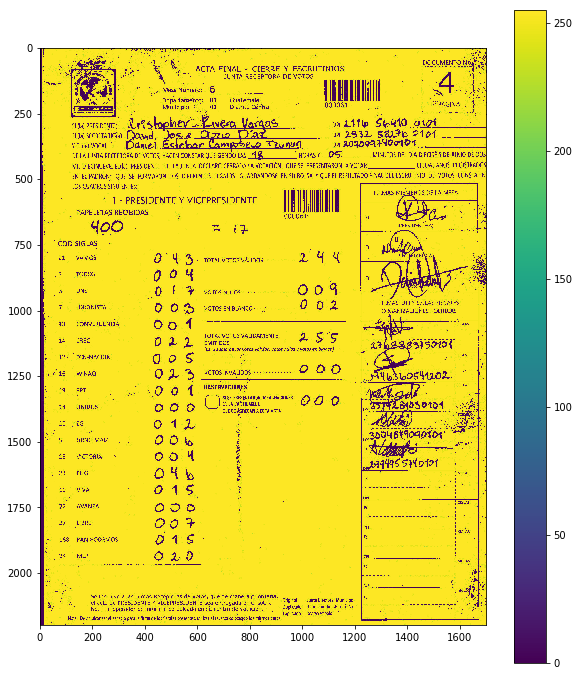

In [79]:
mlp.rcParams["figure.figsize"] = (10,12)
plt.imshow(image)
plt.colorbar()

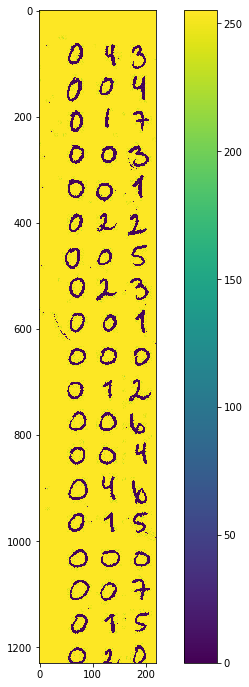

In [80]:
#Extract the form area
crop_img = image[p1[1]:p2[1], p1[0]:p2[0]]

#Extract the party arealut = np.zeros_like(idx)
height, width = crop_img.shape
crop_partidos = crop_img[:,0:width]

# Convert to grayscale and apply Gaussian filtering
im_final=crop_partidos.copy()

plt.imshow(im_final)
plt.colorbar()

In [81]:
crop_img.shape

(1230, 220)

In [82]:
# Threshold the image
ret, im_th = cv2.threshold(im_final, 90, 255, cv2.THRESH_BINARY_INV)

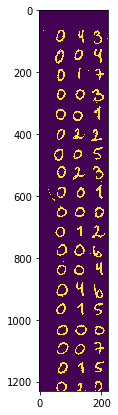

In [83]:
mlp.rcParams["figure.figsize"] = (3,7)
plt.imshow(im_th)

In [90]:
rects=ExtractRectangles(im_th)

(cleaned_rects,cleaned_rects_vcenter,cleaned_rects_hcenter) = CleanRectangles(rects)

npart=19
ndigit=3

In [91]:
im2, ctrs, hie = cv2.findContours(im_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

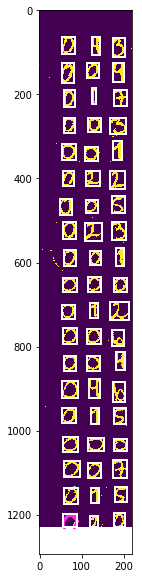

In [92]:
# Visualizando los contornos y rectángulos:
fig, ax = plt.subplots()
ax.imshow(im2)
ax.scatter(ctrs[3][:,0,0], ctrs[3][:,0,1], c="red", s=5) # Rojo
ax.scatter(ctrs[5][:,0,0], ctrs[5][:,0,1], c="#ff22f3", s=5)  # Violeta
ax.scatter(ctrs[15][:,0,0], ctrs[15][:,0,1], c="#22ffff", s=5) # Celeste

for rect in cleaned_rects:
    r = matplotlib.patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], color = "white", linewidth=2, fill=False)
    ax.add_patch(r)

In [93]:
party_lab,party_mean=GetLabels(cleaned_rects_vcenter,npart)

In [94]:
digit_lab,digit_mean=GetLabels(cleaned_rects_hcenter,ndigit)

In [95]:
digit_mean

array([ 70.74, 129.47, 189.26])

In [96]:
votos_sys=CrearCuentasPresidente(mesa)

In [97]:
votos_sys

array([43,  4, 17,  3,  1, 22,  5, 23,  1,  0, 12,  6,  4, 46, 15,  0,  7,
       15, 20])

In [98]:
bad=False
tot=0
rect_pred=np.zeros(len(cleaned_rects)).astype(int)
vote_to_rect={}
bad_rect=[]
party_counts= np.zeros_like(party_lab)
#Predict labels
colors=get_spaced_colors(len(votos_sys)-1)

In [99]:
numeros = []
for i,rect in enumerate(cleaned_rects):
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.2)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    if pt1 < 0:
        pt1=0
    if pt2 < 0:
        pt2=0
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

    #Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    roi = cv2.erode(roi, (6, 6))
    roi = roi / 255
    
    ext_digit = roi.reshape(1,28,28,1)
    prediction= model.predict(ext_digit, verbose = 0)
    val = np.argmax(prediction[0])
    
    numeros.append((pt1,pt2,val,prediction[0][val],roi))


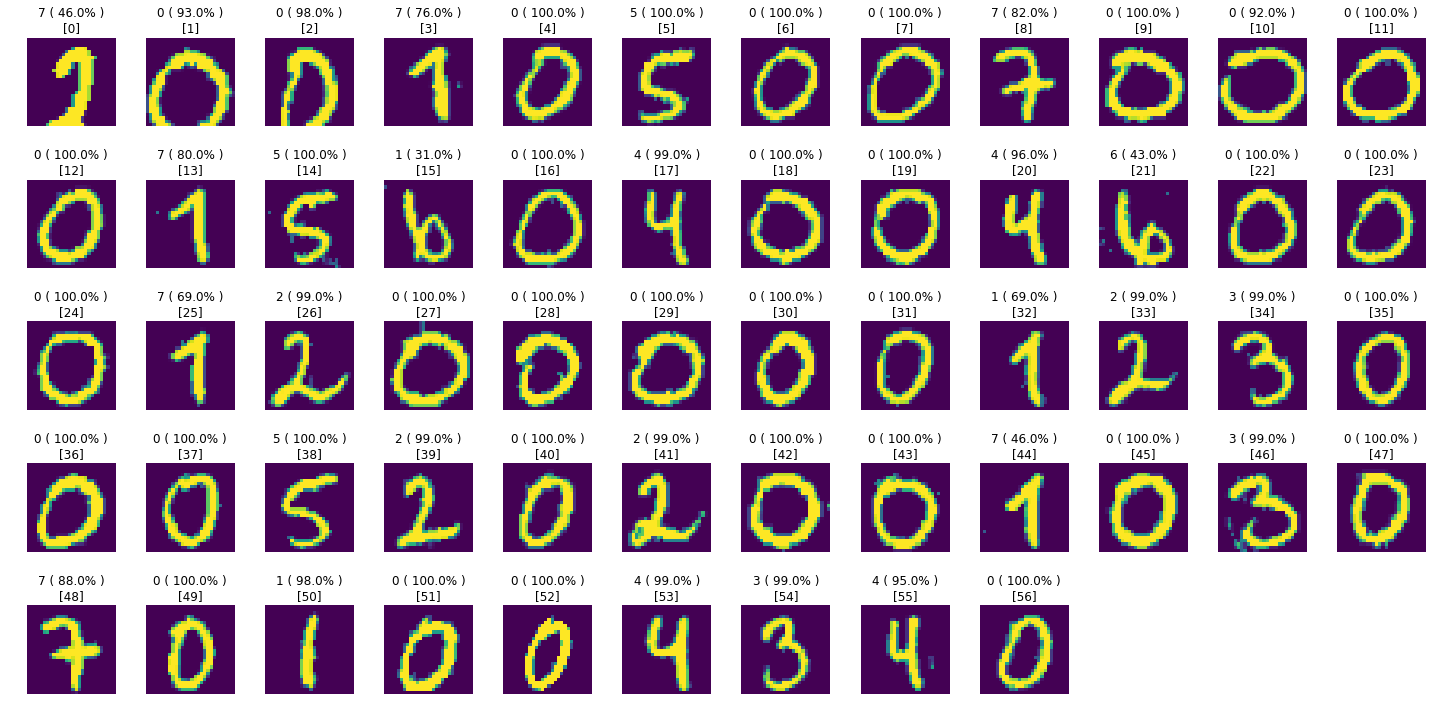

In [105]:
vizNumerosPredichos(numeros)

(array([13.,  6.,  0.,  0.,  7., 12.,  0.,  0.,  4., 15.]),
 array([ 38. ,  51.7,  65.4,  79.1,  92.8, 106.5, 120.2, 133.9, 147.6,
        161.3, 175. ]),
 <a list of 10 Patch objects>)

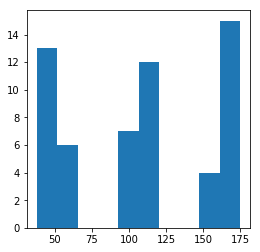

In [106]:
# Las 3 columnas de dígitos:
mlp.rcParams["figure.figsize"] = (4,4)
plt.hist([x[1] for x in numeros])
# 10 < x < 40, col de centenas
# 65 < x < 110, col de centenas
# 115 < x < 145, col de centenas

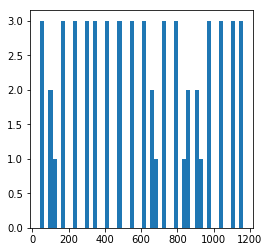

In [288]:
# Las 19 filas:
mlp.rcParams["figure.figsize"] = (4,4)
plt.hist([x[0] for x in numeros], bins=50)
None

In [107]:
# Encontrar los renglones:
row = 0
rows = [[]]
sortedDigits = sorted(numeros, key = lambda x: x[0])
prevy = sortedDigits[0][0]
for n in sortedDigits:
    if np.abs(n[0]-prevy) > 20:
        rows.append([n])
        row +=1
    else:
        rows[row].append(n)
    prevy = n[0]
for i in range(0,len(rows)):
    rows[i] = sorted(rows[i], key=lambda x: x[1])

In [108]:
conteos = [int("".join([str(d[2]) for d in r])) for r in rows ]

In [109]:
# A la izquierda los conteos detectados, y a la derecha los conteos puestos en el json
list(zip(conteos, votos_sys))

[(43, 43),
 (4, 4),
 (17, 17),
 (3, 3),
 (7, 1),
 (22, 22),
 (5, 5),
 (23, 23),
 (1, 1),
 (0, 0),
 (72, 12),
 (6, 6),
 (4, 4),
 (41, 46),
 (75, 15),
 (0, 0),
 (7, 7),
 (75, 15),
 (70, 20)]

# Corrigiendo números mal interpretados

In [112]:
# mesa 1
# trainX = np.array([numeros[x][4].reshape(28,28,1) for x in [1,3,46,24,49]])
# trainY = np.array([ [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,1,0,0] ])

In [147]:
# mesa 6
trainX = np.array([numeros[x][4].reshape(28,28,1) for x in [3,13,25,44,0]])
trainY = np.array([ [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,0,1,0,0,0,0,0,0,0]])

# Probando entrenar el modelo con nuevos casos

In [5]:
l = load_mnist()
# training, validation, and test

In [6]:
l[1][0].shape

(10000, 28, 28, 1)

In [7]:
for i, layer in enumerate(model.model.layers):
    print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f05bcb77a58> False
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7f05bcb77cf8> True
2 <keras.layers.convolutional.Conv2D object at 0x7f05bcb77d30> True
3 <keras.layers.normalization.BatchNormalization object at 0x7f05bcb94208> True
4 <keras.layers.core.Activation object at 0x7f05bcb94ba8> True
5 <keras.layers.convolutional.Conv2D object at 0x7f05bcb62630> True
6 <keras.layers.normalization.BatchNormalization object at 0x7f05bcaa9908> True
7 <keras.layers.core.Activation object at 0x7f05bc1d6080> True
8 <keras.layers.core.Dropout object at 0x7f05bc140da0> True
9 <keras.layers.convolutional.Conv2D object at 0x7f05bc0e7390> True
10 <keras.layers.convolutional.Conv2D object at 0x7f05bc176128> True
11 <keras.layers.merge.Add object at 0x7f05a97c7780> True
12 <keras.layers.normalization.BatchNormalization object at 0x7f05a97c7978> True
13 <keras.layers.core.Activation object at 0x7f05a97e90f0> True
14 <keras.layers.convolutional.C

In [110]:
model.optimizer.decay.initial_value

<tf.Tensor 'SGD/decay/initial_value:0' shape=() dtype=float32>

In [111]:
for layer in range(0,len(model.model.layers)):
    model.model.layers[layer].trainable = False
for layer in [103,104,105]:
    model.model.layers[layer].trainable = True
model.compile()

In [128]:
%%time

# Si no se incluyen los datos de validación del MNIST, el entrenamiento de nuevos casos falla.
# La validación mantiene el entrenamiento original mientras se le agrega nueva información.
# Entrenar con casos nuevos
randsel = np.random.randint(0,l[1][0].shape[0], 2000)
valX = np.concatenate([l[1][0][ randsel,:,:], trainX])
valY = np.concatenate([l[1][1][randsel,:], trainY])
txX = np.concatenate([l[0][0][ randsel,:,:], trainX])
txY = np.concatenate([l[0][1][randsel,:], trainY])
model.fit( (txX, txY), (valX, valY), 4,100)

Train on 2004 samples, validate on 2004 samples
Epoch 1/4
2004/2004 [==============================] - 16s 8ms/step - loss: 0.0753 - acc: 0.9965 - val_loss: 0.0968 - val_acc: 0.9925
Epoch 2/4
2004/2004 [==============================] - 16s 8ms/step - loss: 0.0750 - acc: 0.9965 - val_loss: 0.0941 - val_acc: 0.9925
Epoch 3/4
2004/2004 [==============================] - 16s 8ms/step - loss: 0.0735 - acc: 0.9980 - val_loss: 0.0971 - val_acc: 0.9930
Epoch 4/4
2004/2004 [==============================] - 16s 8ms/step - loss: 0.0759 - acc: 0.9980 - val_loss: 0.0934 - val_acc: 0.9925
CPU times: user 31 s, sys: 8.56 s, total: 39.6 s
Wall time: 1min 3s


In [129]:
numeros = []
for i,rect in enumerate(cleaned_rects):
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.2)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    if pt1 < 0:
        pt1=0
    if pt2 < 0:
        pt2=0
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

    #Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    roi = cv2.erode(roi, (6, 6))
    roi = roi / 255
    
    ext_digit = roi.reshape(1,28,28,1)
    prediction= model.predict(ext_digit, verbose = 0)
    val = np.argmax(prediction[0])
    
    numeros.append((pt1,pt2,val,prediction[0][val],roi))


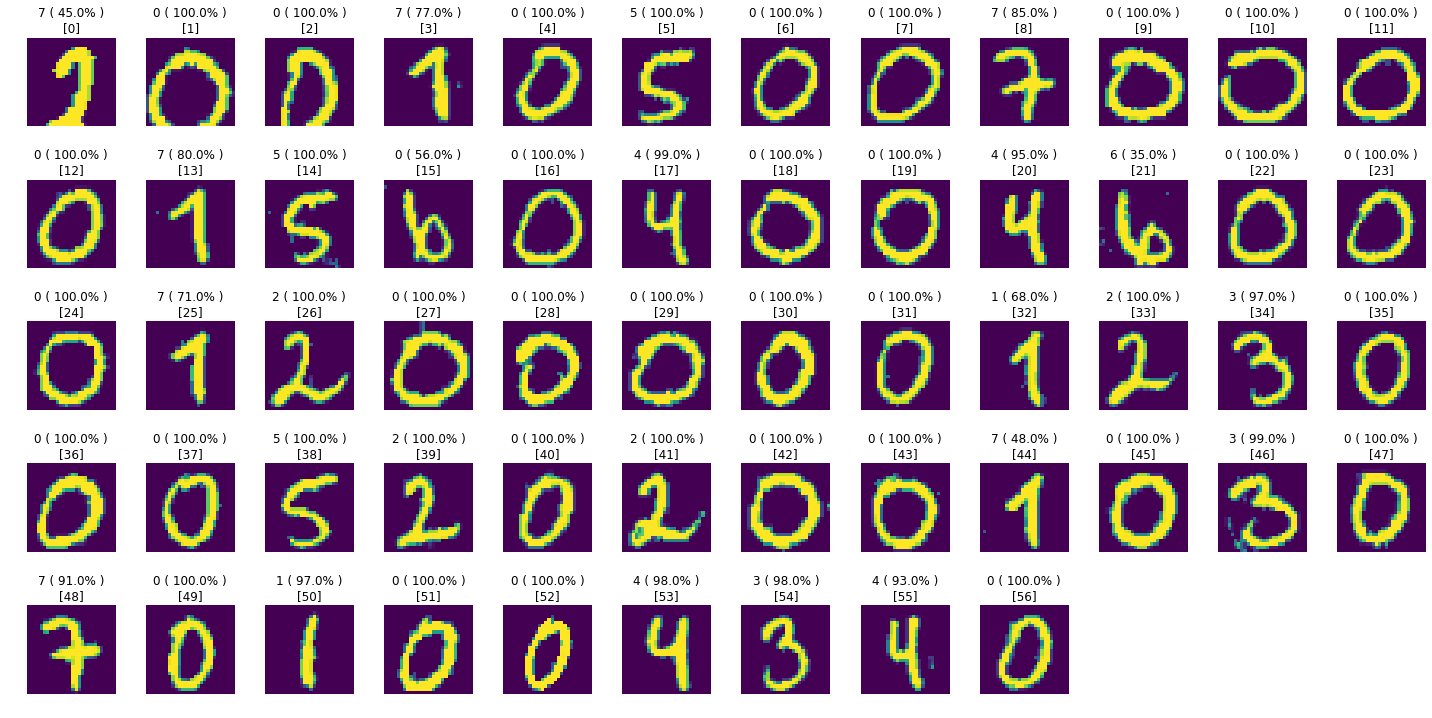

In [130]:
vizNumerosPredichos(numeros)

## Comparar con los resultados de arriba

In [44]:
model.save(PATH + model_name + "_ajustado_1" + '.h5')

# ResNet164

In [506]:
model2_name = "ResNet164"
print('Loading pretrained weights for ', model2_name, '...', sep='')

PATH = './models/'
model2=ResNet164()
model2.compile()

model2.load_weights(PATH + model2_name + '.h5')

Loading pretrained weights for WideResNet28_10...


In [512]:
numerosRN = []
for i,rect in enumerate(cleaned_rects):
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.2)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    if pt1 < 0:
        pt1=0
    if pt2 < 0:
        pt2=0
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

    #Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    roi = cv2.erode(roi, (6, 6))
    roi = roi / 255
    
    ext_digit = roi.reshape(1,28,28,1)
    prediction= model2.predict(ext_digit, verbose = 0)
    val = np.argmax(prediction[0])
    
    numerosRN.append((pt1,pt2,val,prediction[0][val],roi))


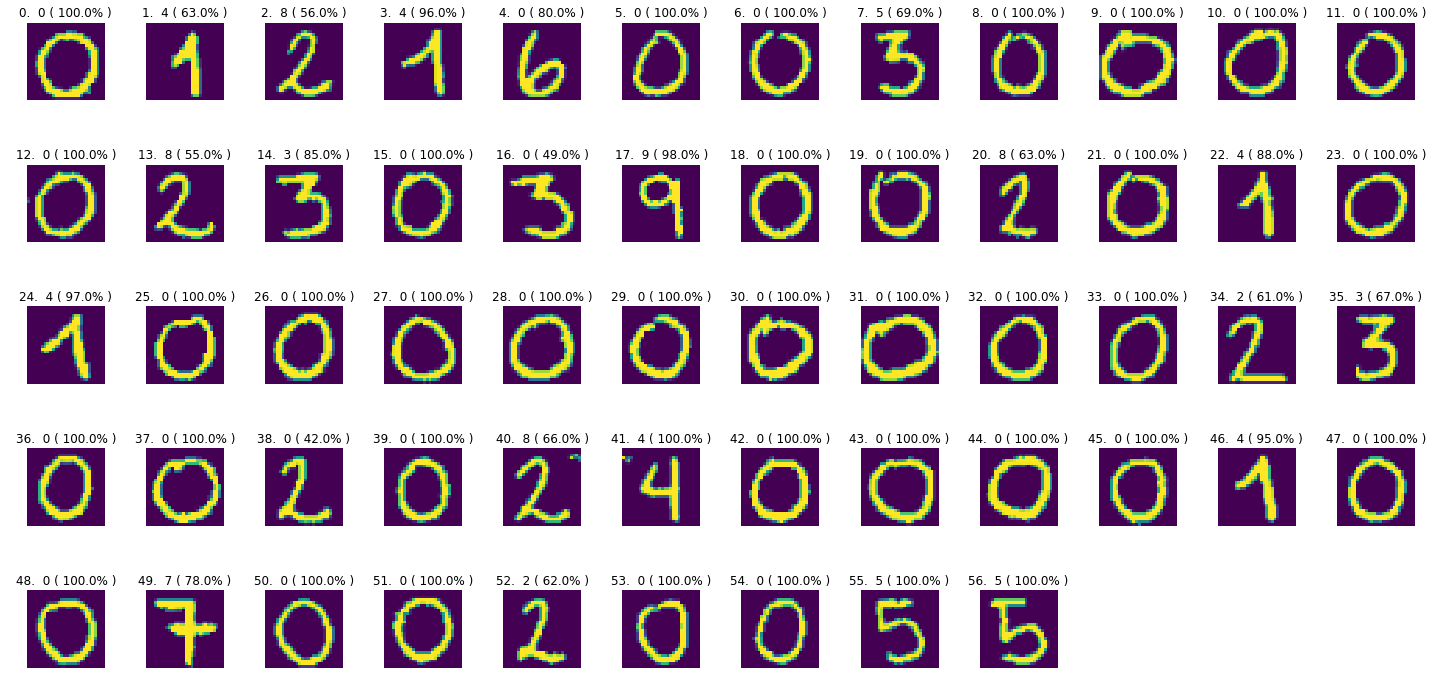

In [513]:
mlp.rcParams["figure.figsize"] = (20,10)
for i in range(0,len(numerosRN)):
    plt.subplot(5, np.ceil(len(numerosRN)/5), i+1)
    plt.imshow(numerosRN[i][4])
    plt.axis("off")
    plt.title("{}.  {} ( {}% )".format(i, numerosRN[i][2], np.round(numerosRN[i][3]*100) ))
plt.tight_layout()

# MobileNet

In [45]:
model3_name = "MobileNet"
PATH = './models/'
model3=MobileNet()
model3.compile()

In [148]:
print('Loading pretrained weights for ', model3_name, '...', sep='')
model3.load_weights(PATH + model3_name + '.h5')

Loading pretrained weights for MobileNet...


In [149]:
numerosMN = []
for i,rect in enumerate(cleaned_rects):
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.2)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    if pt1 < 0:
        pt1=0
    if pt2 < 0:
        pt2=0
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

    #Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    roi = cv2.erode(roi, (6, 6))
    roi = roi / 255
    
    ext_digit = roi.reshape(1,28,28,1)
    prediction= model3.predict(ext_digit, verbose = 0)
    val = np.argmax(prediction[0])
    
    numerosMN.append((pt1,pt2,val,prediction[0][val],roi))


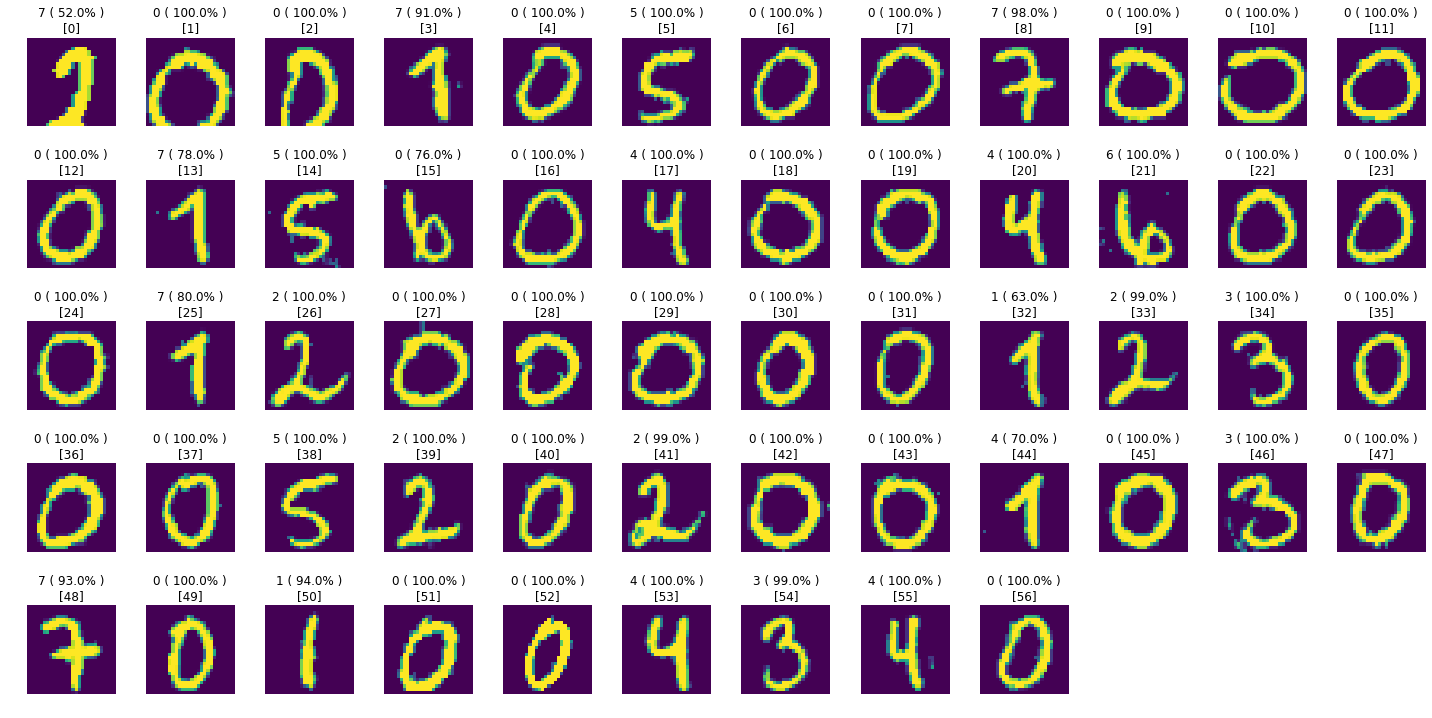

In [150]:
mlp.rcParams["figure.figsize"] = (20,10)
for i in range(0,len(numerosMN)):
    plt.subplot(5, np.ceil(len(numerosMN)/5), i+1)
    plt.imshow(numerosMN[i][4])
    plt.axis("off")
    plt.title("{} ( {}% )\n[{}]".format(numerosMN[i][2], np.round(numerosMN[i][3]*100), i ))
plt.tight_layout()

In [151]:
for layer in range(0,len(model3.model.layers)):
    print(layer, model3.model.layers[layer], model3.model.layers[layer].trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f044c363b38> False
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7f0463f18400> False
2 <keras.layers.convolutional.Conv2D object at 0x7f0463f18630> False
3 <keras.layers.normalization.BatchNormalization object at 0x7f0463f180b8> False
4 <keras.layers.core.Activation object at 0x7f0463ec7438> False
5 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0463ef15c0> False
6 <keras.layers.normalization.BatchNormalization object at 0x7f044c32f9b0> False
7 <keras.layers.core.Activation object at 0x7f0463fe2ba8> False
8 <keras.layers.convolutional.Conv2D object at 0x7f0463f3d390> False
9 <keras.layers.normalization.BatchNormalization object at 0x7f0463f966d8> False
10 <keras.layers.core.Activation object at 0x7f04641a4e48> False
11 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0464087828> False
12 <keras.layers.normalization.BatchNormalization object at 0x7f046c01b470> False
13 <keras.layers.core.Activation object 

In [152]:
for layer in range(0,len(model3.model.layers)):
    model3.model.layers[layer].trainable = False
for layer in [70,71,72,82,83,84,85]:
    model3.model.layers[layer].trainable = True
model3.compile()

In [160]:
%%time
# Entrenar con casos nuevos
randsel = np.random.randint(0,l[1][0].shape[0], 4990)
valX = l[1][0][ randsel,:,:]
valY = l[1][1][randsel,:]
txX = np.concatenate([l[0][0][ randsel,:,:], trainX])
txY = np.concatenate([l[0][1][randsel,:], trainY])
model3.fit_generator( (txX, txY), (valX, valY), 10,100)

Epoch 1/10
49/49 [==============================] - 3s 65ms/step - loss: 0.0048 - acc: 0.9992 - val_loss: 0.0292 - val_acc: 0.9955
Epoch 2/10
49/49 [==============================] - 3s 64ms/step - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0287 - val_acc: 0.9955
Epoch 3/10
49/49 [==============================] - 3s 64ms/step - loss: 0.0070 - acc: 0.9990 - val_loss: 0.0308 - val_acc: 0.9951
Epoch 4/10
49/49 [==============================] - 3s 64ms/step - loss: 0.0041 - acc: 0.9992 - val_loss: 0.0287 - val_acc: 0.9957
Epoch 5/10
49/49 [==============================] - 3s 64ms/step - loss: 0.0070 - acc: 0.9984 - val_loss: 0.0292 - val_acc: 0.9957
Epoch 6/10
49/49 [==============================] - 3s 64ms/step - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0294 - val_acc: 0.9955
Epoch 7/10
49/49 [==============================] - 3s 64ms/step - loss: 0.0052 - acc: 0.9988 - val_loss: 0.0290 - val_acc: 0.9959
Epoch 8/10
49/49 [==============================] - 3s 64ms/step - loss: 0.0062 - a

In [161]:
numerosMN = []
for i,rect in enumerate(cleaned_rects):
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.2)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    if pt1 < 0:
        pt1=0
    if pt2 < 0:
        pt2=0
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

    #Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    roi = cv2.erode(roi, (6, 6))
    roi = roi / 255
    
    ext_digit = roi.reshape(1,28,28,1)
    prediction= model3.predict(ext_digit, verbose = 0)
    val = np.argmax(prediction[0])
    
    numerosMN.append((pt1,pt2,val,prediction[0][val],roi))


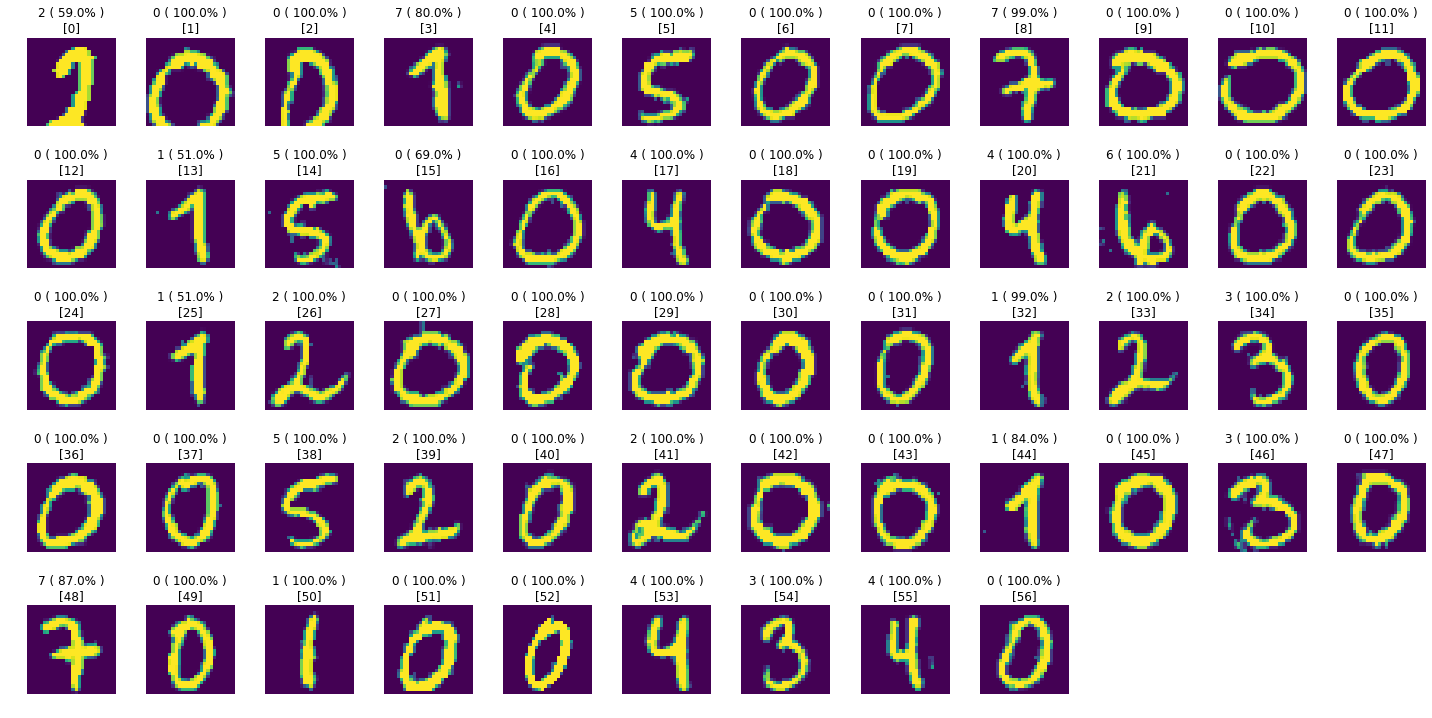

In [162]:
vizNumerosPredichos(numerosMN)

In [163]:
model3.save(PATH + model3_name + "_ajustado_1" + '.h5')

MobileNet se ha dejado entrenar más rápidamente que Wideresnet. 

1